# Car Classify

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from PIL import Image
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
D:\Anaconda3\envs\cv\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## load data
pandas dataframe
dfclass, dftrain, dftest

In [2]:
# orginal image directory. (basedir+'train' and basedir+'test')
basedir = './'
# preprocessed output image directory.
outputdir = './pre/'

# 224, 299
imagesize = 299


# 클래스 데이터 읽기  
dfclass = pd.read_csv(basedir+'class.csv')

FileNotFoundError: File b'./class.csv' does not exist

In [ ]:
dfclass.head()

In [ ]:
# 테스트 데이터 읽기  
dftest = pd.read_csv(basedir+'test.csv')
dftest.head()

In [ ]:
# 훈련 데이터 읽기  
dftrain = pd.read_csv(basedir+'train.csv')
dftrain.head()

In [123]:
# dftrain['class']=dftrain['class']-1  # make class [0,195] from [1,196]
dftrain.describe()

bbox_x1      bbox_y1      bbox_x2      bbox_y2        class
count  9990.000000  9990.000000  9990.000000  9990.000000  9990.000000
mean     64.450250   108.103103   637.145145   416.097097    99.058358
std      80.943666   106.854930   410.671550   274.215428    56.508850
min       1.000000     1.000000    72.000000    46.000000     1.000000
25%      19.000000    41.000000   390.000000   245.000000    51.000000
50%      39.000000    79.000000   570.000000   361.000000    99.000000
75%      78.000000   137.000000   745.000000   476.000000   148.000000
max    1648.000000  1646.000000  5205.000000  3389.000000   196.000000

In [124]:
# shape 형상, 개수 확인   
dftrain.shape, dftest.shape, dfclass.shape

((9990, 6), (6150, 5), (196, 2))

In [125]:
print(dftrain.count(), dftest.count(), dfclass.count())

img_file    9990
bbox_x1     9990
bbox_y1     9990
bbox_x2     9990
bbox_y2     9990
class       9990
dtype: int64 img_file    6150
bbox_x1     6150
bbox_y1     6150
bbox_x2     6150
bbox_y2     6150
dtype: int64 id      196
name    196
dtype: int64


In [126]:
# 빠진 파일 확인 
for f in dftest.img_file:
    if not os.path.exists(basedir+'test/'+f):
        print('not found:', f)

In [127]:
for f in dftrain.img_file:
    if not os.path.exists(basedir+'train/'+f):
        print('not found:', f)

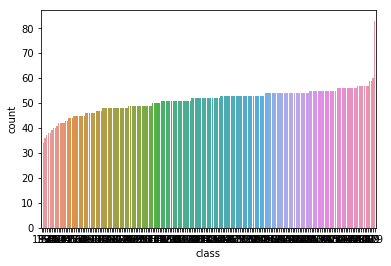

In [128]:
# 클래스별로 개수를 보기. 균일하게 존재하는지 확인.
# 데이터 개수가 학습시 균일할수록 좋다. 한쪽에 너무 치우치면 학습 실패. 
# 마지막에 어떤 클래스의 데이터가 좀 많긴하다. 일단 그대로 학습 진행.. 
sns.countplot(dftrain["class"], order=dftrain["class"].value_counts(ascending=True).index)

In [129]:
# 개수 확인하는 다른 방법. 오름 차순 정렬. 
# dftrain["class"].value_counts(ascending=True)

## image view

(500, 700, 3)
(266, 355, 3)
(194, 259, 3)


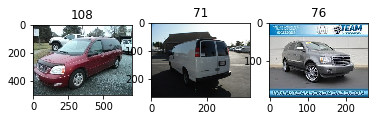

In [130]:
# 이미지 파일 보기 
plt.figure()
pi=0
for i in range(3):
    a = dftrain.img_file[i]
    imgpath = basedir+'train/'+a
    img = plt.imread(imgpath)
    pi+=1
    plt.subplot(1,3,pi)
    plt.title(dftrain["class"][i])
    plt.imshow(img)
    print(img.shape)

./train/train_00001.jpg
(299, 299, 3)
./train/train_00002.jpg
(299, 299, 3)
./train/train_00003.jpg
(299, 299, 3)


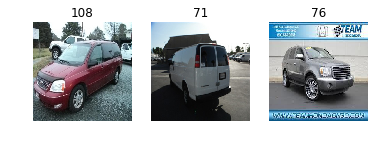

In [131]:
# 크기가 제각각인 이미지. 리사이즈.
# resize??? (224,224,3)

pi=0
for i in range(3):
    a = dftrain.img_file[i]
    imgpath = basedir+'train/'+a
    print(imgpath)
    pi+=1
    plt.subplot(1,3,pi)
    plt.title(dftrain["class"][i])
    plt.axis('off')
    imgobj = Image.open(imgpath)
    imgobj = imgobj.resize((imagesize,imagesize))
    img_r = np.asarray(imgobj)
    plt.imshow(img_r)
    print(img_r.shape)

In [132]:
# 바인딩 박스 정보 확인. test
print(i, img.shape)
print(dftrain.loc[i])
bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
print(bb)

2 (194, 259, 3)
img_file    train_00003.jpg
bbox_x1                  35
bbox_y1                  42
bbox_x2                 227
bbox_y2                 160
class                    76
Name: 2, dtype: object
[35, 42, 227, 160]


## bounding box

In [133]:
# 이미지에 박스 그리기 
def bound(img, x1,y1,x2,y2):
    img[y1,x1:x2] = [255,0,0]
    img[y2,x1:x2] = [255,0,0]
    img[y1:y2,x1] = [255,0,0]
    img[y1:y2,x2] = [255,0,0]
    return img


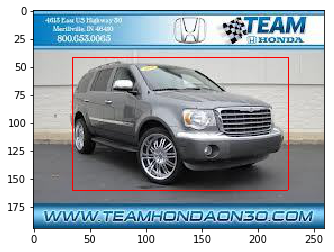

In [134]:
img2 = np.copy(img)
img2=bound(img2, bb[0], bb[1], bb[2], bb[3])
plt.imshow(img2)

In [135]:
# 바인딩 박스가 이미지 리사이즈시 새로운 박스 위치를 찾기
# bb, width, height
def resize_bb(bb, w, h):
    rx = imagesize/w
    ry = imagesize/h
    return [int(bb[0]*rx), int(bb[1]*ry), int(bb[2]*rx), int(bb[3]*ry)]

bb2=resize_bb(bb, img.shape[1], img.shape[0])
print(bb, bb2)

[35, 42, 227, 160] [40, 64, 262, 246]


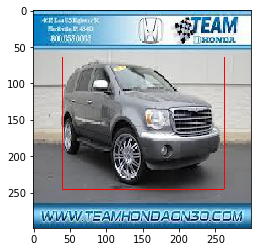

In [136]:
img2 = np.copy(img_r)
img2=bound(img2, bb2[0], bb2[1], bb2[2], bb2[3])
plt.imshow(img2)

## Training dataset preprocessing

image (224,224,3) shape. 3 channels. crop box area.


In [137]:
# 이미지를 바인딩 박스만 추출하여 리사이즈 한다. (차만 보이게 추출하고 리사이즈)
''' crop and resize '''
def prepro_img(imgpath, bb=None, margin=20, size=(224,224)):
    img = Image.open(imgpath)
    img = img.convert('RGB')  # 3 channel image.
    imgn = np.asarray(img)

    #crop
    imgc = imgn
    if bb!=None:
        h, w, c = imgn.shape
        x1 = max(0, bb[0]-margin)
        y1 = max(0, bb[1]-margin)
        x2 = min(bb[2]+margin, w)
        y2 = min(bb[3]+margin, h)
    #     imgc = imgn[bb[1]:bb[3], bb[0]:bb[2]]
        imgc = imgn[y1:y2, x1:x2]
    
    newimg = imgc
    if size!=None:
        imgcobj = Image.fromarray(imgc)
        imgcobj2 = imgcobj.resize(size)
        newimg = np.asarray(imgcobj2)
    return newimg

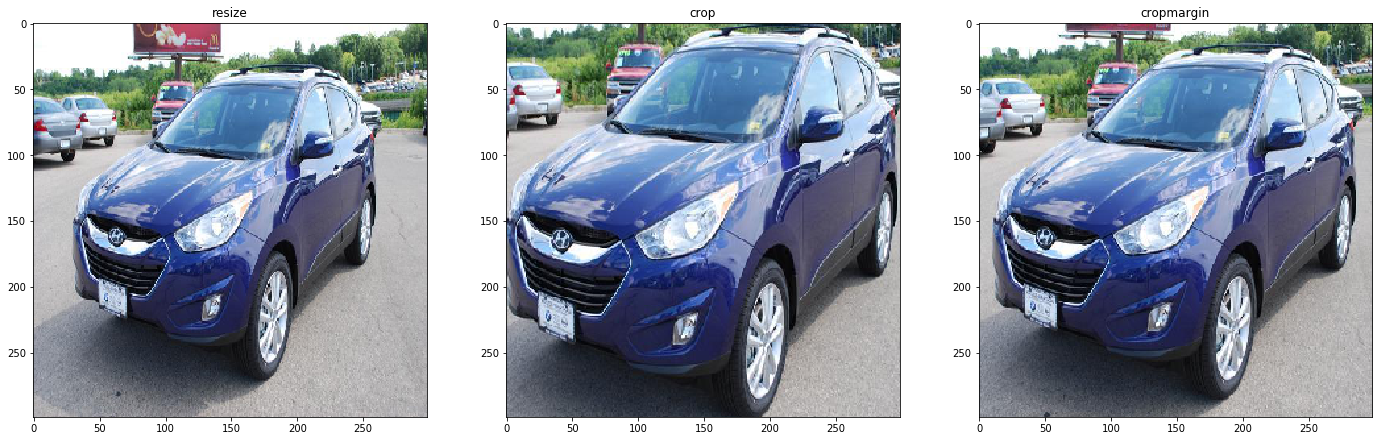

In [138]:
# preprocess test
i=100
imgpath = basedir+'train/'+dftrain.loc[i]['img_file']
bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
cl = dftrain.loc[i]['class']

# size=(400,400)
size = (imagesize, imagesize)
plt.figure(figsize=(8*3, 8))
plt.subplot(1,3,1)
plt.title('resize')
plt.imshow(prepro_img(imgpath, None, 0, size))

plt.subplot(1,3,2)
plt.title('crop')
plt.imshow(prepro_img(imgpath, bb, 0, size))

plt.subplot(1,3,3)
plt.title('cropmargin')
plt.imshow(prepro_img(imgpath, bb, 20, size))
plt.show()

## Make Train dataset

In [24]:
# 훈련 데이터 만들기. 
#      주의! class값 범위는 0~195로 조정하여 저장. 실제 클래스값(1~196)을 알려면 +1 필요.
# crop and resize하여 저장
# make train data numpy 

cnt_train = dftrain.shape[0]
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
if not os.path.exists(outputdir+'train'):
    os.mkdir(outputdir+'train')
if not os.path.exists(outputdir+'test'):
    os.mkdir(outputdir+'test')

for i in range(cnt_train):
    if i%1000==0 :
        print(i, '/', cnt_train)
    imgpath = 'train/'+dftrain.loc[i]['img_file']
    bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
    cl = dftrain.loc[i]['class']
    test1 = prepro_img(imgpath, bb, 20, (imagesize, imagesize))
    test1obj = Image.fromarray(test1)
    test1obj.save(outputdir+'train/'+dftrain.loc[i]['img_file'])


0 / 9990
1000 / 9990
2000 / 9990
3000 / 9990
4000 / 9990
5000 / 9990
6000 / 9990
7000 / 9990
8000 / 9990
9000 / 9990


In [31]:
# 테스트 데이터도 전처리하여 저장한다.
# make test data numpy 
cnt_test = dftest.shape[0]
for i in range(cnt_test):
    if i%1000==0 :
        print(i, '/', cnt_test)
    imgpath = 'test/'+dftest.loc[i]['img_file']
    bb = [dftest.loc[i]['bbox_x1'], dftest.loc[i]['bbox_y1'], dftest.loc[i]['bbox_x2'], dftest.loc[i]['bbox_y2']]
    test1 = prepro_img(imgpath, bb, 20, (imagesize, imagesize))
    test1obj = Image.fromarray(test1)
    test1obj.save(outputdir+'test/'+dftest.loc[i]['img_file'])


0 / 6150
1000 / 6150
2000 / 6150
3000 / 6150
4000 / 6150
5000 / 6150
6000 / 6150


[2783 5739 3512  698 5202]


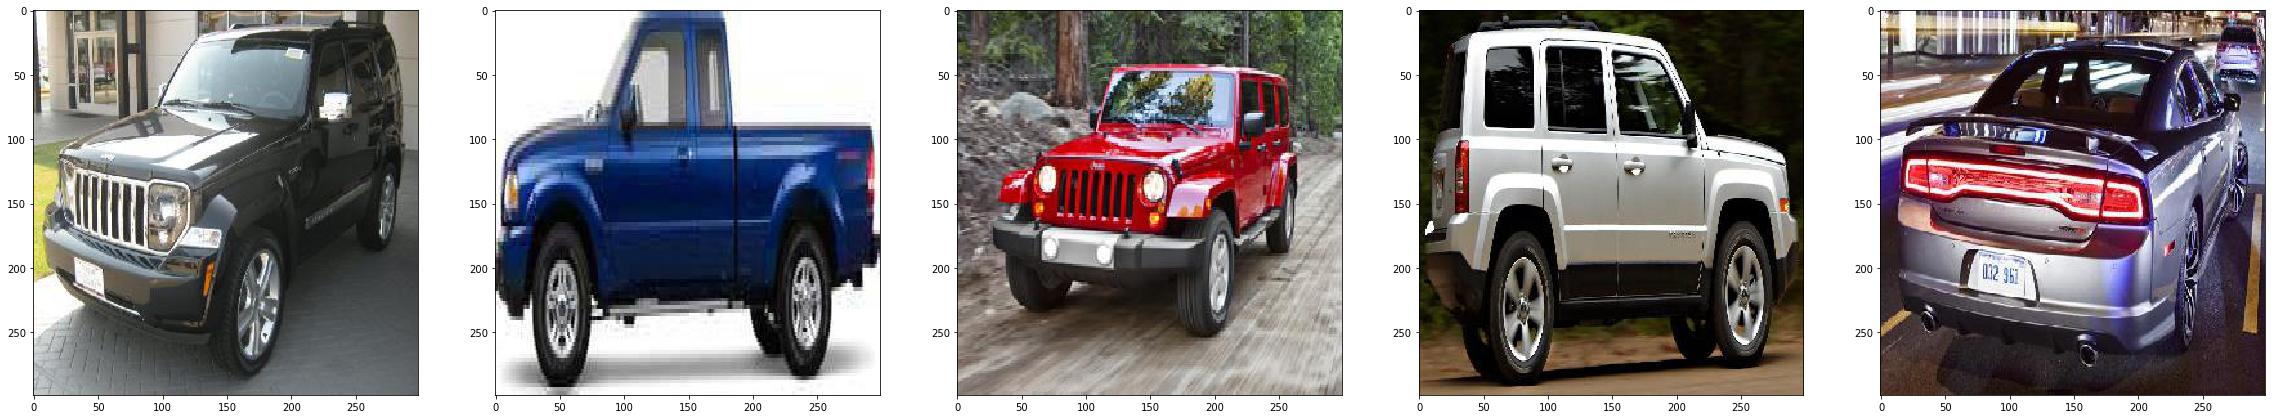

In [139]:
# preprocessed train data random view
ri = np.random.randint(0, 6000, 5)
print(ri)
plt.figure(figsize=(len(ri)*8, 8))
for a,i in enumerate(ri):
    plt.subplot(1,len(ri), a+1)
    img = Image.open( outputdir+'train/'+dftrain.loc[i]['img_file'] )
    img = img.convert('RGB')  # 3 channel image.
    imgn = np.asarray(img)
    plt.imshow(imgn)
plt.show()

[4796 5665 4290 2027  990]


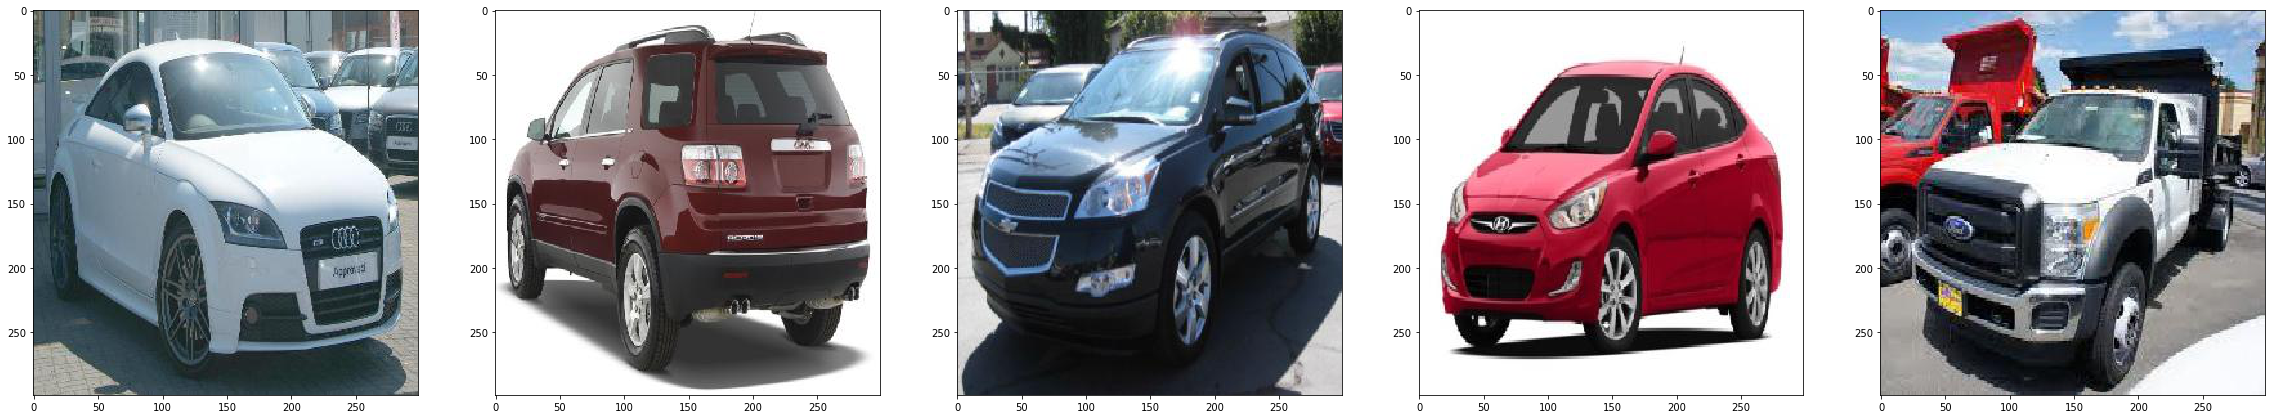

In [140]:
# preprocessed test data random view
ri = np.random.randint(0, 6000, 5)
print(ri)
plt.figure(figsize=(len(ri)*8, 8))
for a,i in enumerate(ri):
    plt.subplot(1,len(ri), a+1)
    img = Image.open( outputdir+'test/'+dftest.loc[i]['img_file'] )
    img = img.convert('RGB')  # 3 channel image.
    imgn = np.asarray(img)    
    plt.imshow(imgn)
plt.show()

In [141]:
print(imgn.dtype)
print(imgn.shape)

uint8
(299, 299, 3)


In [142]:
#ref: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

In [143]:
dftrain.head()
# dftrain.info()

img_file  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class
0  train_00001.jpg        1       80      641      461    108
1  train_00002.jpg       57       53      293      236     71
2  train_00003.jpg       35       42      227      160     76
3  train_00004.jpg       10       21      254      165    188
4  train_00005.jpg        1       67      772      573     44

In [144]:
dftrain['class'] = dftrain['class'].astype('str')

In [156]:
# classes = list (dftrain['class'].unique())
# print(classes)
classes = list (str(num) for num in range(1,197))
print(classes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '

Found 9990 validated image filenames belonging to 196 classes.
len augs= 2
augs[1]= [ 10 165 170  98 135 118  16 159 193  86  48   1  31  10 157 189]
imgs.shape= (16, 256, 256, 3)
['108']
['71']
['76']
['188']
['44']
['29']
['113']
['66']
['97']
['177']
['142']
['10']
['127']
['108']
['64']
['93']


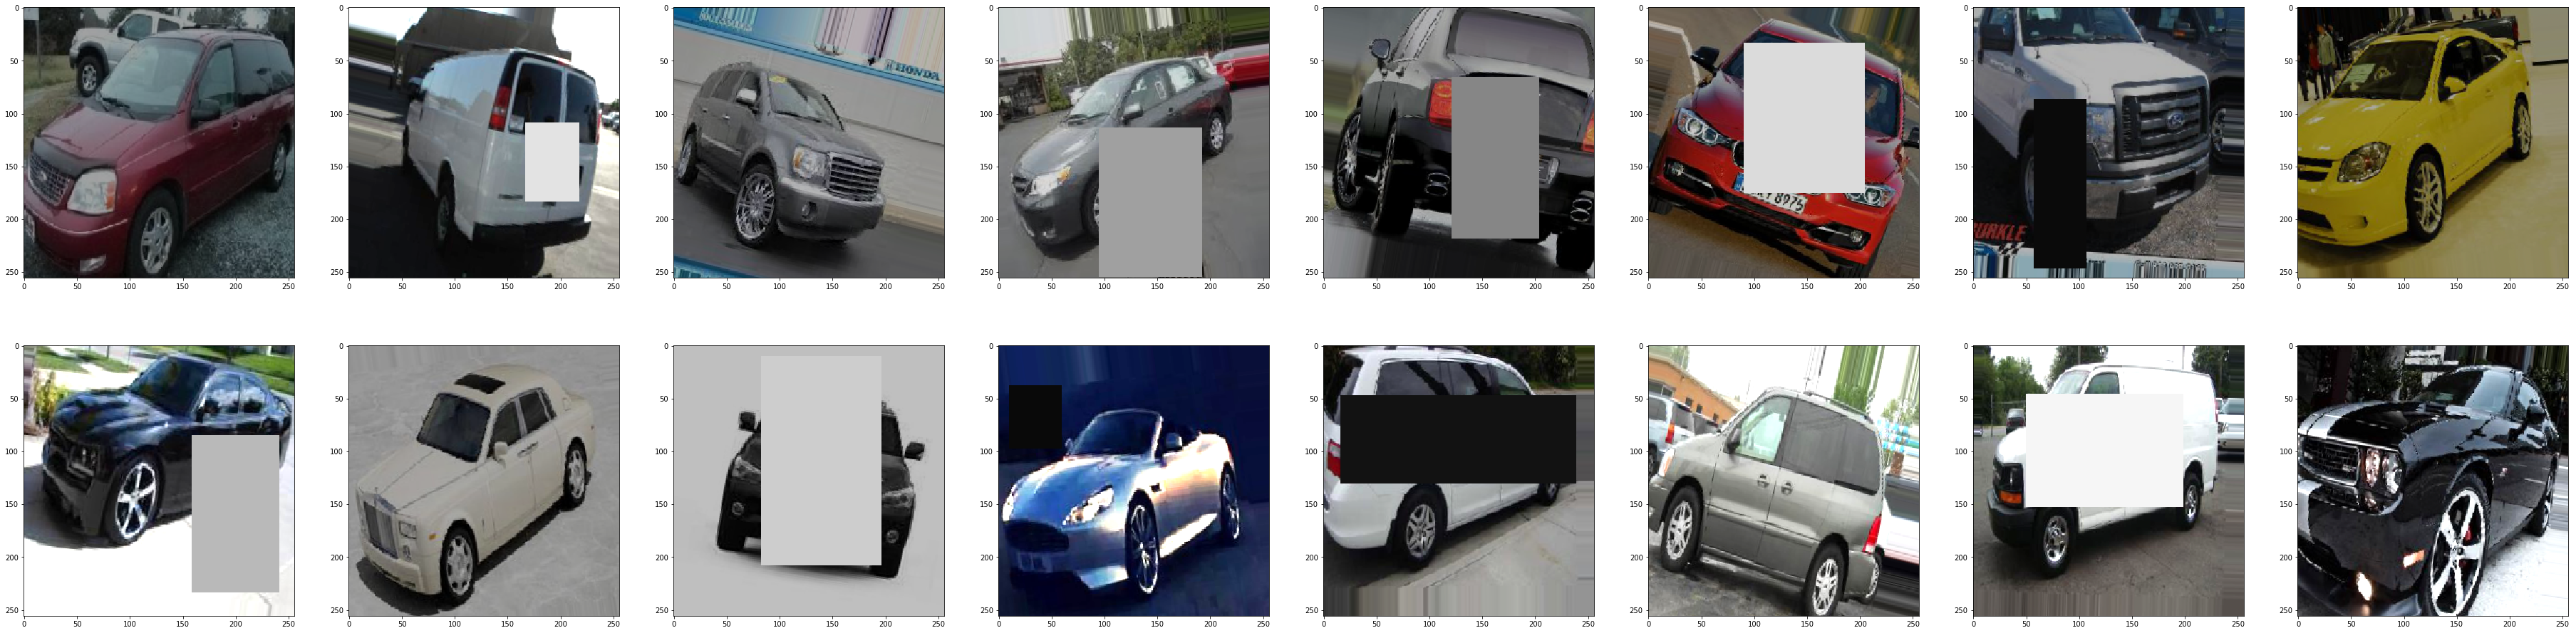

In [157]:
# image test
# import gc
# gc.collect()

if True:
    datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, 
                                  horizontal_flip=True, vertical_flip=False,
                                  width_shift_range=0.1, height_shift_range=0.1, 
                                  rotation_range=15, brightness_range=[0.5, 1.5],
                                  fill_mode='nearest', preprocessing_function = get_random_eraser(v_l=0, v_h=255),)    
#     train_generator = datagen1.flow(x_test, batch_size=16)
    train_generator = datagen1.flow_from_dataframe( dataframe=dftrain, 
                                                   directory=outputdir+'train', 
                                                   x_col = 'img_file', 
                                                   y_col = 'class', 
                                                   target_size = (imagesize, imagesize),
                                                   class_mode='categorical', 
                                                   classes = classes,
                                                   batch_size=16, 
                                                  seed=100, 
                                                  shuffle=False)
    augs = train_generator.__getitem__(0)
    i=0
    plt.figure(figsize=(8*8, 8*2))
    print('len augs=', len(augs))
    print('augs[1]=', np.argmax(augs[1], axis=1))
    for imgs in augs:
        print('imgs.shape=', imgs.shape)
        # get batch_size count aug images
        for img in imgs:
            cl =[ name for name, v in train_generator.class_indices.items() if v==np.argmax(augs[1][i]) ]
            print(cl)
            i+=1
            plt.subplot(2, 8, i)
            plt.imshow(img)
            if i==16:
                break
        break
    plt.show()
    del augs

In [158]:
train_generator.class_indices

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '103': 5,
 '104': 6,
 '105': 7,
 '106': 8,
 '107': 9,
 '108': 10,
 '109': 11,
 '11': 12,
 '110': 13,
 '111': 14,
 '112': 15,
 '113': 16,
 '114': 17,
 '115': 18,
 '116': 19,
 '117': 20,
 '118': 21,
 '119': 22,
 '12': 23,
 '120': 24,
 '121': 25,
 '122': 26,
 '123': 27,
 '124': 28,
 '125': 29,
 '126': 30,
 '127': 31,
 '128': 32,
 '129': 33,
 '13': 34,
 '130': 35,
 '131': 36,
 '132': 37,
 '133': 38,
 '134': 39,
 '135': 40,
 '136': 41,
 '137': 42,
 '138': 43,
 '139': 44,
 '14': 45,
 '140': 46,
 '141': 47,
 '142': 48,
 '143': 49,
 '144': 50,
 '145': 51,
 '146': 52,
 '147': 53,
 '148': 54,
 '149': 55,
 '15': 56,
 '150': 57,
 '151': 58,
 '152': 59,
 '153': 60,
 '154': 61,
 '155': 62,
 '156': 63,
 '157': 64,
 '158': 65,
 '159': 66,
 '16': 67,
 '160': 68,
 '161': 69,
 '162': 70,
 '163': 71,
 '164': 72,
 '165': 73,
 '166': 74,
 '167': 75,
 '168': 76,
 '169': 77,
 '17': 78,
 '170': 79,
 '171': 80,
 '172': 81,
 '173': 82,
 '174': 83,
 '175': 84,
